In [142]:
import pandas as pd
data = pd.read_csv('bankrupt.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bianh         6272 non-null   int64  
 1   com_name      6272 non-null   object 
 2   com_addr      6272 non-null   object 
 3   cat           6272 non-null   object 
 4   se_cat        6271 non-null   object 
 5   com_des       6271 non-null   object 
 6   born_data     6272 non-null   object 
 7   death_data    6272 non-null   object 
 8   live_days     6272 non-null   int64  
 9   financing     6272 non-null   object 
 10  total_money   805 non-null    float64
 11  death_reason  1419 non-null   object 
 12  invest_name   600 non-null    object 
 13  ceo_name      4839 non-null   object 
 14  ceo_des       4838 non-null   object 
 15  ceo_per_des   4839 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory usage: 784.1+ KB


In [143]:
data['com_addr'].unique()

array(['上海', '浙江', '广东', '福建', '北京', '湖南', '江苏', '四川', '陕西', '河北', '吉林',
       '湖北', '河南', '天津', '贵州', '山东', '重庆', '辽宁', '安徽', '江西', '亚洲', '北美洲',
       '广西', '山西', '黑龙江', '香港', '新疆', '台湾', '青海', '云南', '甘肃', '欧洲', '海南',
       '内蒙古', '宁夏', '西藏', '北京 '], dtype=object)

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['font.sans-serif']=['Kaiti SC']
plt.rcParams['axes.unicode_minus']=False   

[Text(2, 0, '79'),
 Text(2, 0, '83'),
 Text(2, 0, '117'),
 Text(2, 0, '140'),
 Text(2, 0, '253'),
 Text(2, 0, '282'),
 Text(2, 0, '395'),
 Text(2, 0, '1034'),
 Text(2, 0, '1095'),
 Text(2, 0, '2238')]

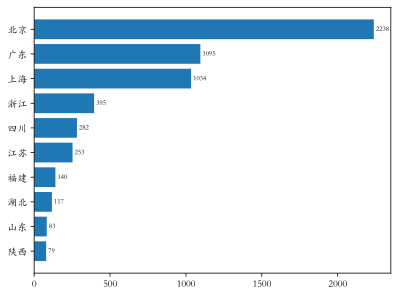

In [145]:
geo_dis = data.groupby('com_addr').size().nlargest(10)
geo_dis = geo_dis.iloc[::-1]
geo_dis.index.name = ''
chart = plt.barh(geo_dis.index,geo_dis.values)
# bar_chart = geo_dis.plot.barh(color='k',alpha=0.7)
# bar_chart.spines['right'].set_visible(False)
plt.bar_label(chart,label_type='edge',size=7,padding=2)



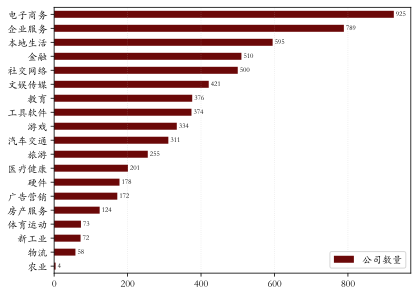

In [146]:
industry_dis = data.pivot_table(index=['cat'],values='com_name',aggfunc='count').sort_values(by='com_name')
industry_dis.rename(columns={'com_name':'公司数量'},inplace=True)
industry_dis.index.name=''
axes = industry_dis.plot.barh(color='#6B0808')
axes.bar_label(axes.containers[0],label_type='edge',padding=2,size=7)
axes.grid(linestyle=':',axis='x',alpha=0.3)

## 行业细分分析

Text(0, 0.5, '')

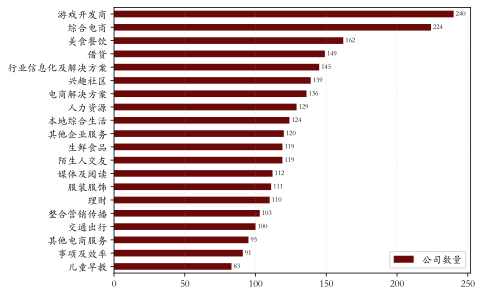

In [147]:
section_dis = data.pivot_table(index=['se_cat'],values='com_name',aggfunc='count').nlargest(columns='com_name',n=20)[::-1]
section_dis.rename(columns={'com_name':'公司数量'},inplace=True)
chart = section_dis.plot.barh(color='#6B0808')
chart.bar_label(chart.containers[0],label_type='edge',size=7,padding=2)
chart.grid(linestyle=':',axis='x',alpha=0.3)
chart.set_ylabel('')



## 年份分析

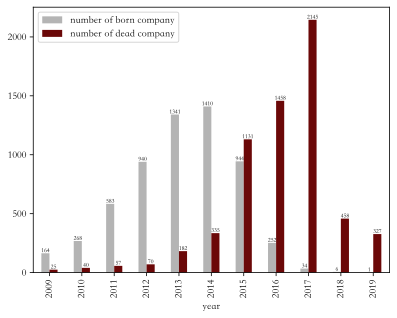

In [148]:
data['born_year'] = data['born_data'].str.split('-').str[0].astype(int)
data['death_year'] = data['death_data'].str.split('-').str[0].astype(int)

max_born_year = data['born_year'].max()
born_yr_cmp_count = data.groupby('born_year').size().loc[max_born_year-10:max_born_year]
born_yr_cmp_count.index.name='year'
born_yr_cmp_count.name = 'number of born company'


max_death_year = data['death_year'].max()
death_yr_cmp_count = data.groupby('death_year').size().loc[max_death_year-10:max_death_year]
death_yr_cmp_count.index.name='year'
death_yr_cmp_count.name = 'number of dead company'

chart = pd.merge(born_yr_cmp_count,death_yr_cmp_count,on='year').plot.bar(color=['#B4B4B4','#6B0808'])

for container in chart.containers:
    chart.bar_label(container,size=6,color='k')




## 存活时长分析

<Axes: >

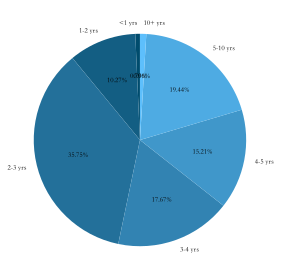

In [182]:

data = data[data['live_days'] >= 0]
bins = [0,365-1,365*2-1,365*3-1,365*4-1,365*5-1,365*10-1,float('inf')]
labels = ['<1 yrs', '1-2 yrs', '2-3 yrs', '3-4 yrs', '4-5 yrs', '5-10 yrs', '10+ yrs']
data['survival time category'] = pd.cut(data['live_days'],bins=bins,labels=labels)
data.groupby('survival time category',observed=True).size().plot.pie(
    textprops={'fontsize': 7},
    colors=['#004c6d','#135e83','#23709a','#3283b2','#4097ca','#4eabe3','#5dbffc'],
    startangle=90,
    autopct='%1.2f%%'
)